## Data Analysis: Concept-Based Interventions for Academic Integrity
### This notebook presents the analysis of concept-based interventions designed to reduce cheating behavior. The analysis addresses three main research questions:
    RQ1: Do concept-based interventions reduce cheating behavior?
    RQ2: Do interventions affect performance and user experience?
    RQ3: How do interventions influence outcomes through psychological mechanisms?

#### 1. Setup and Data Preparation

In [1]:
# =============================================================================
# IMPORTS
# =============================================================================
import sys, os, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle, Patch
from scipy.stats import chi2_contingency, f_oneway, pearsonr, ttest_ind, mannwhitneyu, chi2
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn.inspection import permutation_importance

warnings.filterwarnings('ignore')

# Data path (data folder is at parent level of game-behavior-analytics)
os.chdir('game-behavior-analytics/analysis_notebook/')
DATA_PATH = '../../data/'

In [2]:
# =============================================================================
# DATA LOADING AND PREPARATION
# =============================================================================

# cheating_experiment_dataset.csv contains only objective measures of final_dataset.csv
df = pd.read_csv(f"{DATA_PATH}cheating_experiment_dataset.csv") 

# Create integrity groups based on cheating behavior
df['cheating_behavior'] = df['cheating_behavior'].fillna(0)
df['integrity_group'] = pd.cut(
    df['cheating_behavior'],
    bins=[-0.001, 0.001, 0.999, 1.001],
    labels=['non_cheaters', 'partial_cheaters', 'full_cheaters']
)

# Create condition variable
df['condition'] = df['concept'].apply(
    lambda x: 'control' if pd.isna(x) else ('intervention' if x == 'intervention' else x)
)

# Combine all intervention concepts into a single "intervention" condition
intervention_combined = df[df['condition'] != 'control'].copy()
intervention_combined['condition'] = 'intervention'
df_combined = pd.concat([df, intervention_combined], ignore_index=True)

print(f"Total participants: {len(df)}")
print(f"Control: {len(df[df['condition'] == 'control'])}")
print(f"Intervention: {len(df[df['condition'] != 'control'])}")

Total participants: 1232
Control: 73
Intervention: 1159


In [3]:
# =============================================================================
# CONFIGURATION: Concept and Mechanism Definitions
# =============================================================================

# Concept ordering and display names
CONCEPT_ORDER = [
    'control', 'intervention',
    'autonomy', 'competence', 'relatedness', 'self_concept',
    'cognitive_inconsistency', 'dissonance_arousal', 'dissonance_reduction',
    'descriptive_norms', 'injunctive_norms', 'social_sanctions',
    'reference_group_identification', 'performance_accomplishments',
    'vicarious_experience', 'verbal_persuasion', 'emotional_arousal'
]

CONCEPT_DISPLAY = {
    'control': 'Control', 'intervention': 'Intervention',
    'autonomy': 'Autonomy (SDT)', 'competence': 'Competence (SDT)',
    'relatedness': 'Relatedness (SDT)', 'self_concept': 'Self Concept (SDT)',
    'cognitive_inconsistency': 'Cognitive Inconsistency (CDT)',
    'dissonance_arousal': 'Dissonance Arousal (CDT)',
    'dissonance_reduction': 'Dissonance Reduction (CDT)',
    'descriptive_norms': 'Descriptive Norms (SNT)',
    'injunctive_norms': 'Injunctive Norms (SNT)',
    'social_sanctions': 'Social Sanctions (SNT)',
    'reference_group_identification': 'Ref. Group Identity (SNT)',
    'performance_accomplishments': 'Perf. Accomplishments (SET)',
    'vicarious_experience': 'Vicarious Experience (SET)',
    'verbal_persuasion': 'Verbal Persuasion (SET)',
    'emotional_arousal': 'Emotional Arousal (SET)'
}

# Mechanism definitions
MECHANISMS = [
    'autonomy_need_satisfaction', 'autonomy_need_frustration',
    'competence_need_satisfaction', 'competence_need_frustration',
    'relatedness_need_satisfaction', 'relatedness_need_frustration',
    'cognitive_discomfort', 'moral_disengagement',
    'injunctive_norms', 'descriptive_norms',
    'social_sanctions', 'reference_group_identification',
    'performance_accomplishments', 'vicarious_experience',
    'verbal_persuasion', 'emotional_arousal'
]

MECHANISM_DISPLAY = {
    'autonomy_need_satisfaction': 'Autonomy Satisfaction',
    'autonomy_need_frustration': 'Autonomy Frustration',
    'competence_need_satisfaction': 'Competence Satisfaction',
    'competence_need_frustration': 'Competence Frustration',
    'relatedness_need_satisfaction': 'Relatedness Satisfaction',
    'relatedness_need_frustration': 'Relatedness Frustration',
    'cognitive_discomfort': 'Cognitive Discomfort',
    'moral_disengagement': 'Moral Disengagement',
    'injunctive_norms': 'Percv. Injunctive Norms',
    'descriptive_norms': 'Percv. Descriptive Norms',
    'social_sanctions': 'Percv. Social Sanctions',
    'reference_group_identification': 'Percv. Ref. Group Identity',
    'performance_accomplishments': 'Percv. Perf. Accomplishments',
    'vicarious_experience': 'Percv. Vicarious Experience',
    'verbal_persuasion': 'Percv. Verbal Persuasion',
    'emotional_arousal': 'Percv. Emotional Arousal'
}

# Color scheme for integrity groups
INTEGRITY_COLORS = {
    'non_cheaters': '#4bb4ff',
    'partial_cheaters': '#f9ac53', 
    'full_cheaters': '#e85943'
}

# Bootstrap settings
N_BOOTSTRAP = 1000

In [4]:
# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

def compute_integrity_distribution(data):
    """Compute percentage distribution of integrity groups by condition."""
    result = data.groupby(['condition', 'integrity_group']).size().reset_index(name='n')
    totals = result.groupby('condition')['n'].sum().reset_index(name='total')
    result = result.merge(totals, on='condition')
    result['percent'] = (result['n'] / result['total']) * 100
    return result[['condition', 'integrity_group', 'percent']]

def fishers_z_test(r1, n1, r2, n2):
    """Compare two correlation coefficients using Fisher's Z-transformation."""
    z1, z2 = np.arctanh(r1), np.arctanh(r2)
    se = np.sqrt(1/(n1-3) + 1/(n2-3))
    z_stat = (z1 - z2) / se
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
    return z_stat, p_value, r1 - r2

def likelihood_ratio_test(X_scaled, y):
    """Compare full model vs null model using likelihood ratio test."""
    m1 = LogisticRegression(random_state=42, max_iter=1000)
    m1.fit(X_scaled, y)
    
    m0 = LogisticRegression(random_state=42, max_iter=1000)
    m0.fit(np.ones((len(X_scaled), 1)), y)
    
    ll_m1 = -log_loss(y, m1.predict_proba(X_scaled), normalize=False)
    ll_m0 = -log_loss(y, m0.predict_proba(np.ones((len(X_scaled), 1))), normalize=False)
    
    lr_stat = 2 * (ll_m1 - ll_m0)
    df = X_scaled.shape[1]
    p_value = 1 - chi2.cdf(lr_stat, df)
    pseudo_r2 = 1 - (ll_m1 / ll_m0)
    
    return lr_stat, df, p_value, pseudo_r2

def sig_stars(p):
    """Return significance stars for p-value."""
    if p < 0.001: return '***'
    if p < 0.01: return '**'
    if p < 0.05: return '*'
    return 'ns'

#### 2. RQ1: Do Concept-Based Interventions Reduce Cheating Behavior?
##### This section examines whether concept-based interventions reduce cheating behavior and whether effects vary across different concepts.
**Methods:** Chi-square tests comparing integrity group distributions- 95% bootstrapped confidence intervals (1000 iterations)

In [5]:
# =============================================================================
# RQ1: Bootstrap Confidence Intervals
# =============================================================================

boot_results = []
for _ in range(N_BOOTSTRAP):
    sample = df_combined.sample(n=len(df_combined), replace=True)
    boot_results.append(compute_integrity_distribution(sample))

boot_df = pd.concat(boot_results, ignore_index=True)
ci_df = boot_df.groupby(['condition', 'integrity_group'])['percent'].agg([
    ('mean', 'mean'),
    ('lower', lambda x: np.percentile(x, 2.5)),
    ('upper', lambda x: np.percentile(x, 97.5))
]).reset_index()

# Add sample sizes
sample_sizes = df_combined.groupby(['condition', 'integrity_group']).size().reset_index(name='n')
ci_df = ci_df.merge(sample_sizes, on=['condition', 'integrity_group'], how='left')

In [6]:
# =============================================================================
# RQ1: Chi-Square Tests
# =============================================================================

print("="*70)
print("CHI-SQUARE TESTS: Integrity Group Distribution (Control vs Intervention)")
print("="*70)

for group in ['non_cheaters', 'partial_cheaters', 'full_cheaters']:
    ctrl = df_combined[(df_combined['condition'] == 'control') & 
                       (df_combined['integrity_group'] == group)]
    intv = df_combined[(df_combined['condition'] == 'intervention') & 
                       (df_combined['integrity_group'] == group)]
    
    ctrl_total = len(df_combined[df_combined['condition'] == 'control'])
    intv_total = len(df_combined[df_combined['condition'] == 'intervention'])
    
    contingency = [[len(ctrl), ctrl_total - len(ctrl)],
                   [len(intv), intv_total - len(intv)]]
    
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency)
    
    ctrl_pct = len(ctrl) / ctrl_total * 100
    intv_pct = len(intv) / intv_total * 100
    rel_change = (intv_pct - ctrl_pct) / ctrl_pct * 100
    
    print(f"\n{group.replace('_', '-').title()}:")
    print(f"  Control: {ctrl_pct:.1f}% | Intervention: {intv_pct:.1f}%")
    print(f"  Relative change: {rel_change:+.1f}%")
    print(f"  χ²({dof}) = {chi2_stat:.2f}, p = {p_val:.4f} {sig_stars(p_val)}")

CHI-SQUARE TESTS: Integrity Group Distribution (Control vs Intervention)

Non-Cheaters:
  Control: 53.4% | Intervention: 63.3%
  Relative change: +18.5%
  χ²(1) = 2.47, p = 0.1157 ns

Partial-Cheaters:
  Control: 13.7% | Intervention: 17.5%
  Relative change: +27.9%
  χ²(1) = 0.46, p = 0.4985 ns

Full-Cheaters:
  Control: 32.9% | Intervention: 19.2%
  Relative change: -41.7%
  χ²(1) = 7.26, p = 0.0071 **


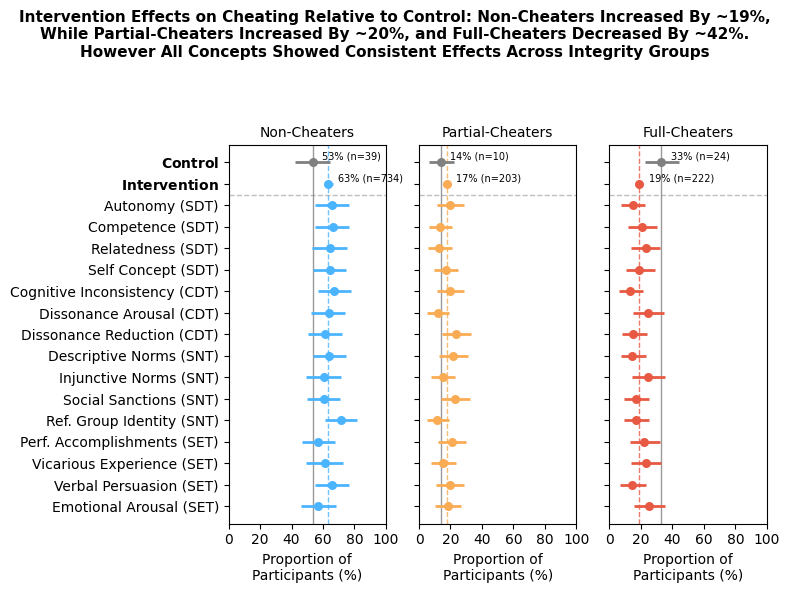

In [7]:
# =============================================================================
# FIGURE 4.6: Integrity Distribution by Concept (Forest Plots)
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(8, 6), sharey=True)
integrity_groups = ['non_cheaters', 'partial_cheaters', 'full_cheaters']
colors = ['#4bb4ff', '#f9ac53', '#e85943']
titles = ['Non-Cheaters', 'Partial-Cheaters', 'Full-Cheaters']

formatted_labels = [f'$\\bf{{{CONCEPT_DISPLAY[c]}}}$' if c in ['control', 'intervention'] 
                    else CONCEPT_DISPLAY[c] for c in CONCEPT_ORDER]

for idx, (ax, group, color, title) in enumerate(zip(axes, integrity_groups, colors, titles)):
    data = ci_df[ci_df['integrity_group'] == group]
    data = data.set_index('condition').reindex(CONCEPT_ORDER).reset_index()
    
    y = np.arange(len(CONCEPT_ORDER))
    
    for i, row in data.iterrows():
        c = 'gray' if row['condition'] == 'control' else color
        ax.scatter(row['mean'], y[i], color=c, s=30, zorder=3)
        ax.hlines(y[i], row['lower'], row['upper'], color=c, linewidth=2, zorder=2)
    
    for _, row in data.iterrows():
        if row['condition'] in ['control', 'intervention']:
            ax.text(row['mean'] + 6, y[list(data['condition']).index(row['condition'])] - 0.25,
                    f"{row['mean']:.0f}% (n={row['n']})", va='center', ha='left', fontsize=7)
    
    ax.set_title(title, fontsize=10)
    ax.set_yticks(y)
    ax.set_yticklabels(formatted_labels, fontsize=10)
    ax.set_xlim(0, 100)
    ax.set_xticks([0, 20, 40, 60, 80, 100])
    ax.set_xlabel('Proportion of\nParticipants (%)', fontsize=10)
    ax.axhline(y=1.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
    ctrl_mean = data.loc[data['condition'] == 'control', 'mean'].values[0]
    ax.axvline(x=ctrl_mean, color='gray', linestyle='-', linewidth=1, alpha=0.8, zorder=1)
    
    int_mean = data.loc[data['condition'] == 'intervention', 'mean'].values[0]
    ax.axvline(x=int_mean, color=color, linestyle='--', linewidth=1, alpha=0.8, zorder=1)
    ax.invert_yaxis()

fig.suptitle(
    'Intervention Effects on Cheating Relative to Control: Non-Cheaters Increased By ~19%,\n'
    'While Partial-Cheaters Increased By ~20%, and Full-Cheaters Decreased By ~42%.\n'
    'However All Concepts Showed Consistent Effects Across Integrity Groups',
    fontsize=11, fontweight='bold', y=0.98
)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig('integrity_distribution_by_concept.png', dpi=300, bbox_inches='tight')
plt.show()

#### 3. RQ2: Do Interventions Affect Performance and User Experience?
##### This section examines whether concept-based interventions affect performance and experience across integrity groups.
**Methods:** Welch's t-test and Mann-Whitney U test- Pearson correlations between perceived ability and performance

In [8]:
# =============================================================================
# RQ2: Prepare Data with "All" Category
# =============================================================================

df_tmp = df_combined.copy()
df_tmp['integrity_group'] = 'all'
df_all = pd.concat([df_combined, df_tmp], ignore_index=True)
df_all['integrity_group'] = pd.Categorical(
    df_all['integrity_group'],
    categories=['non_cheaters', 'partial_cheaters', 'full_cheaters', 'all'],
    ordered=True
)

In [9]:
# =============================================================================
# RQ2: Summary Statistics and Statistical Tests
# =============================================================================

def analyze_metric(df_all, df_combined, metric, label):
    """Compute summary statistics and statistical tests for a metric."""
    integrity_groups = ['non_cheaters', 'partial_cheaters', 'full_cheaters', 'all']
    
    print(f"\n{'='*70}")
    print(f"{label.upper()} ANALYSIS")
    print("="*70)
    
    # Summary statistics
    print(f"\n--- Summary by Integrity Group and Condition ---")
    for group in integrity_groups:
        plot_data = df_combined if group == 'all' else df_all[df_all['integrity_group'] == group]
        plot_data = plot_data[plot_data['condition'].isin(['control', 'intervention'])]
        
        for cond in ['control', 'intervention']:
            vals = plot_data[plot_data['condition'] == cond][metric].dropna()
            print(f"{group:20s} {cond:12s}: N={len(vals):4d}, M={vals.mean():.2f}, SD={vals.std():.2f}")
    
    # Statistical tests
    print(f"\n--- Welch's t-test and Mann-Whitney U (Control vs Intervention) ---")
    for group in integrity_groups:
        plot_data = df_combined if group == 'all' else df_all[df_all['integrity_group'] == group]
        plot_data = plot_data[plot_data['condition'].isin(['control', 'intervention'])]
        
        ctrl = plot_data[plot_data['condition'] == 'control'][metric].dropna()
        intv = plot_data[plot_data['condition'] == 'intervention'][metric].dropna()
        
        t_stat, p_t = ttest_ind(intv, ctrl, equal_var=False)
        u_stat, p_u = mannwhitneyu(intv, ctrl, alternative='two-sided')
        
        print(f"\n{group.replace('_', '-').title()}:")
        print(f"  Welch t-test: t={t_stat:.3f}, p={p_t:.4f} {sig_stars(p_t)}")
        print(f"  Mann-Whitney: U={u_stat:.1f}, p={p_u:.4f} {sig_stars(p_u)}")

analyze_metric(df_all, df_combined, 'performance', 'Performance')
analyze_metric(df_all, df_combined, 'experience', 'Experience')


PERFORMANCE ANALYSIS

--- Summary by Integrity Group and Condition ---
non_cheaters         control     : N=  39, M=14.67, SD=7.91
non_cheaters         intervention: N= 734, M=17.19, SD=10.37
partial_cheaters     control     : N=  10, M=20.60, SD=11.85
partial_cheaters     intervention: N= 203, M=17.94, SD=9.18
full_cheaters        control     : N=  24, M=30.25, SD=13.85
full_cheaters        intervention: N= 222, M=27.73, SD=13.73
all                  control     : N=  73, M=20.60, SD=12.73
all                  intervention: N=1159, M=19.34, SD=11.64

--- Welch's t-test and Mann-Whitney U (Control vs Intervention) ---

Non-Cheaters:
  Welch t-test: t=1.909, p=0.0626 ns
  Mann-Whitney: U=15881.5, p=0.2476 ns

Partial-Cheaters:
  Welch t-test: t=-0.699, p=0.5011 ns
  Mann-Whitney: U=897.0, p=0.5358 ns

Full-Cheaters:
  Welch t-test: t=-0.848, p=0.4038 ns
  Mann-Whitney: U=2329.0, p=0.3119 ns

All:
  Welch t-test: t=-0.825, p=0.4121 ns
  Mann-Whitney: U=39954.0, p=0.4249 ns

EXPERIENCE A

In [10]:
# =============================================================================
# RQ2: High Score Distribution (40-50 Range)
# =============================================================================

print("\n" + "="*70)
print("HIGH SCORES (40-50 Range) BY INTEGRITY GROUP")
print("="*70)

for group in ['non_cheaters', 'partial_cheaters', 'full_cheaters']:
    data = df_all[df_all['integrity_group'] == group]
    for cond in ['control', 'intervention']:
        scores = data[data['condition'] == cond]['performance'].dropna()
        n_high = ((scores >= 40) & (scores < 50)).sum()
        pct = n_high / len(scores) * 100
        print(f"{group:20s} {cond:12s}: {n_high:3d}/{len(scores):3d} ({pct:4.1f}%)")


HIGH SCORES (40-50 Range) BY INTEGRITY GROUP
non_cheaters         control     :   0/ 39 ( 0.0%)
non_cheaters         intervention:  22/734 ( 3.0%)
partial_cheaters     control     :   1/ 10 (10.0%)
partial_cheaters     intervention:   2/203 ( 1.0%)
full_cheaters        control     :   4/ 24 (16.7%)
full_cheaters        intervention:  39/222 (17.6%)


In [11]:
# =============================================================================
# RQ2: Perceived Ability - Performance Correlations
# =============================================================================

print("\n" + "="*70)
print("PERCEIVED ABILITY - PERFORMANCE CORRELATIONS BY INTEGRITY GROUP")
print("="*70)

df_int = df_combined[df_combined['condition'] == 'intervention'].copy()

for group in ['non_cheaters', 'partial_cheaters', 'full_cheaters']:
    group_data = df_int[df_int['integrity_group'] == group][['perceived_ability', 'performance']].dropna()
    if len(group_data) > 2:
        r, p = pearsonr(group_data['perceived_ability'], group_data['performance'])
        print(f"{group.replace('_', '-').title():20s}: r={r:.3f}, p={p:.4f} {sig_stars(p)}")


PERCEIVED ABILITY - PERFORMANCE CORRELATIONS BY INTEGRITY GROUP
Non-Cheaters        : r=0.143, p=0.0001 ***
Partial-Cheaters    : r=-0.117, p=0.0970 ns
Full-Cheaters       : r=0.072, p=0.2867 ns


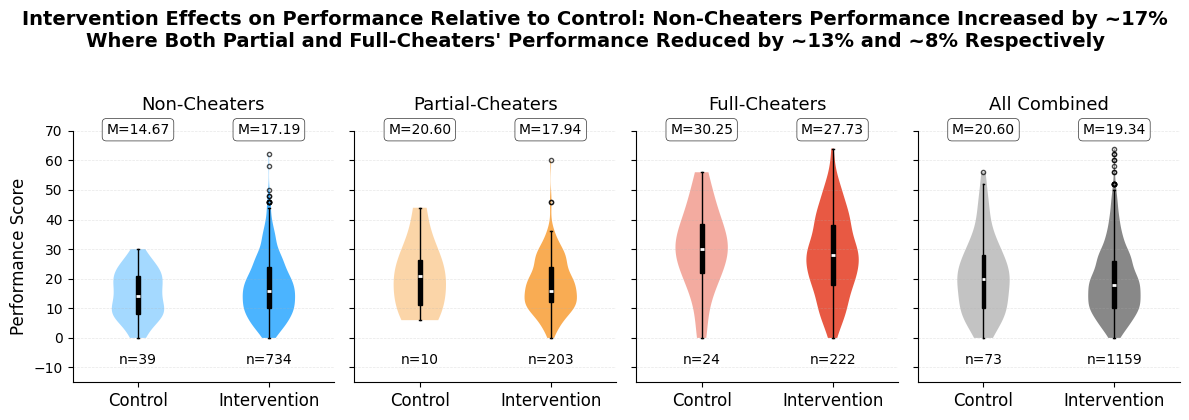

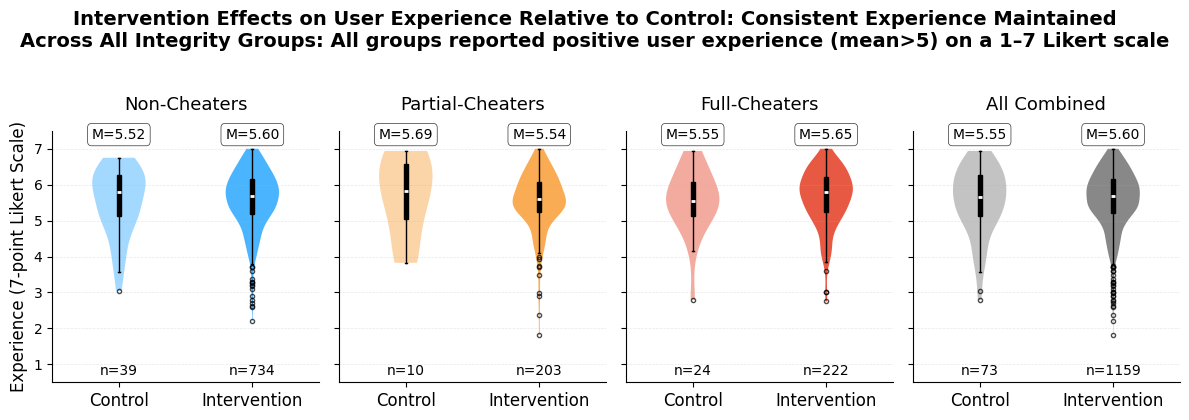

In [12]:
# =============================================================================
# FIGURE 4.7: Performance and Experience Distributions (Violin Plots)
# =============================================================================

def plot_metric(df_all, df_combined, metric, label, y_label, y_lim, mean_ypos, n_ypos, subtitle):
    """Create violin + box plots for a metric across integrity groups and conditions."""
    integrity_groups = ['non_cheaters', 'partial_cheaters', 'full_cheaters', 'all']
    titles = ['Non-Cheaters', 'Partial-Cheaters', 'Full-Cheaters', 'All Combined']

    fig, axes = plt.subplots(1, 4, figsize=(12, 5), sharey=True)
    for idx, (ax, group, title) in enumerate(zip(axes, integrity_groups, titles)):
        plot_data = df_combined if group == 'all' else df_all[df_all['integrity_group'] == group]
        plot_data = plot_data[plot_data['condition'].isin(['control', 'intervention'])]

        control_data = plot_data[plot_data['condition'] == 'control'][metric].dropna()
        intervention_data = plot_data[plot_data['condition'] == 'intervention'][metric].dropna()

        # Violin + box
        parts = ax.violinplot([control_data, intervention_data], positions=[0, 1], widths=0.4,
                              showmeans=False, showmedians=False, showextrema=False)
        ax.boxplot([control_data, intervention_data], positions=[0, 1], widths=0.03,
                   patch_artist=True,
                   boxprops=dict(facecolor='black', color='black'),
                   medianprops=dict(color='white', linewidth=2),
                   whiskerprops=dict(color='black', linewidth=1),
                   capprops=dict(color='black', linewidth=1),
                   flierprops=dict(marker='o', markersize=3, markeredgecolor='black', alpha=0.7))

        # Color violins for control vs intervention
        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor(INTEGRITY_COLORS.get(group, '#888888'))
            pc.set_alpha(0.5 if i == 0 else 1.0)  # control lighter, intervention full
            pc.set_linewidth(1)

        # Annotate
        for pos, condition_data in enumerate([control_data, intervention_data]):
            ax.text(pos, n_ypos, f'n={len(condition_data)}', ha='center', va='top', fontsize=10)
            ax.text(pos, mean_ypos, f'M={condition_data.mean():.2f}', ha='center', va='bottom',
                    fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black', linewidth=0.5, alpha=0.8))

        ax.set_title(title, fontsize=13, pad=15)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['Control', 'Intervention'], fontsize=12)
        ax.set_ylim(*y_lim)
        if idx == 0:
            ax.set_ylabel(y_label, fontsize=12)
        ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    fig.suptitle(subtitle, fontsize=14, fontweight='bold', y=0.93)
    plt.tight_layout(rect=[0, 0.1, 1, 0.90])
    plt.show()

# Performance plot
plot_metric(
    df_all, df_combined, 'performance', 'Performance',
    'Performance Score', (-15, 70), mean_ypos=68, n_ypos=-5,
    subtitle="Intervention Effects on Performance Relative to Control: Non-Cheaters Performance Increased by ~17%\n"
    "Where Both Partial and Full-Cheaters' Performance Reduced by ~13% and ~8% Respectively",
)

# Experience plot
plot_metric(
    df_all, df_combined, 'experience', 'Experience',
    'Experience (7-point Likert Scale)', (0.5, 7.5), mean_ypos=7.2, n_ypos=1,
    subtitle="Intervention Effects on User Experience Relative to Control: Consistent Experience Maintained\n"
    "Across All Integrity Groups: All groups reported positive user experience (mean>5) on a 1–7 Likert scale"
 )

#### 4. RQ3: Mechanisms Through Which Interventions Influence Outcomes
##### This section explores the psychological pathways through which concept-based interventions influence cheating behavior, performance, and experience.
##### 4.1. Concept → Mechanism Effects: Do concept-based messages affect self-reported psychological mechanisms as intended?

In [13]:
# =============================================================================
# FIGURE 4.9: Concept → Mechanism Heatmap
# =============================================================================

df_int = df_combined[df_combined['concept'].notna()].copy()
concept_order_filtered = [c for c in CONCEPT_ORDER if c != 'intervention']

# Calculate concept means for mechanisms
concept_means = df_int.groupby('concept')[MECHANISMS].mean()
control_means = concept_means.loc['control']

# Calculate deviations from control
concepts_without_control = [c for c in concept_order_filtered if c != 'control']
relative_data = concept_means.loc[concepts_without_control].subtract(control_means, axis=1)

# Effect size statistics
all_diffs = relative_data.values.flatten()
print("="*70)
print("EFFECT SIZE STATISTICS (Concept Effects on Mechanisms)")
print("="*70)
print(f"Mean difference from control: {np.mean(all_diffs):.2f}")
print(f"SD: {np.std(all_diffs):.2f}")
print(f"Max: {np.max(all_diffs):.2f} ({np.max(all_diffs)/np.std(all_diffs):.1f} SD)")

# Theory-specific effects
theory_effects = {
    'SDT': (['autonomy', 'competence', 'relatedness'], 
            ['autonomy_need_satisfaction', 'autonomy_need_frustration',
             'competence_need_satisfaction', 'competence_need_frustration',
             'relatedness_need_satisfaction', 'relatedness_need_frustration']),
    'CDT': (['self_concept', 'cognitive_inconsistency', 'dissonance_arousal', 'dissonance_reduction'],
            ['cognitive_discomfort', 'moral_disengagement']),
    'SNT': (['descriptive_norms', 'injunctive_norms', 'social_sanctions', 'reference_group_identification'],
            ['injunctive_norms', 'descriptive_norms', 'social_sanctions', 'reference_group_identification']),
    'SET': (['performance_accomplishments', 'vicarious_experience', 'verbal_persuasion', 'emotional_arousal'],
            ['performance_accomplishments', 'vicarious_experience', 'verbal_persuasion', 'emotional_arousal'])
}

for theory, (concepts, mechs) in theory_effects.items():
    diffs = [relative_data.loc[c, m] for c in concepts if c in relative_data.index 
             for m in mechs if m in relative_data.columns]
    if diffs:
        print(f"{theory}: Range=[{min(diffs):.2f}, {max(diffs):.2f}], Mean={np.mean(diffs):.2f}")

EFFECT SIZE STATISTICS (Concept Effects on Mechanisms)
Mean difference from control: 0.07
SD: 0.28
Max: 0.82 (3.0 SD)
SDT: Range=[-0.67, 0.43], Mean=-0.02
CDT: Range=[-0.26, 0.07], Mean=-0.05
SNT: Range=[-0.30, 0.31], Mean=-0.01
SET: Range=[0.38, 0.82], Mean=0.55


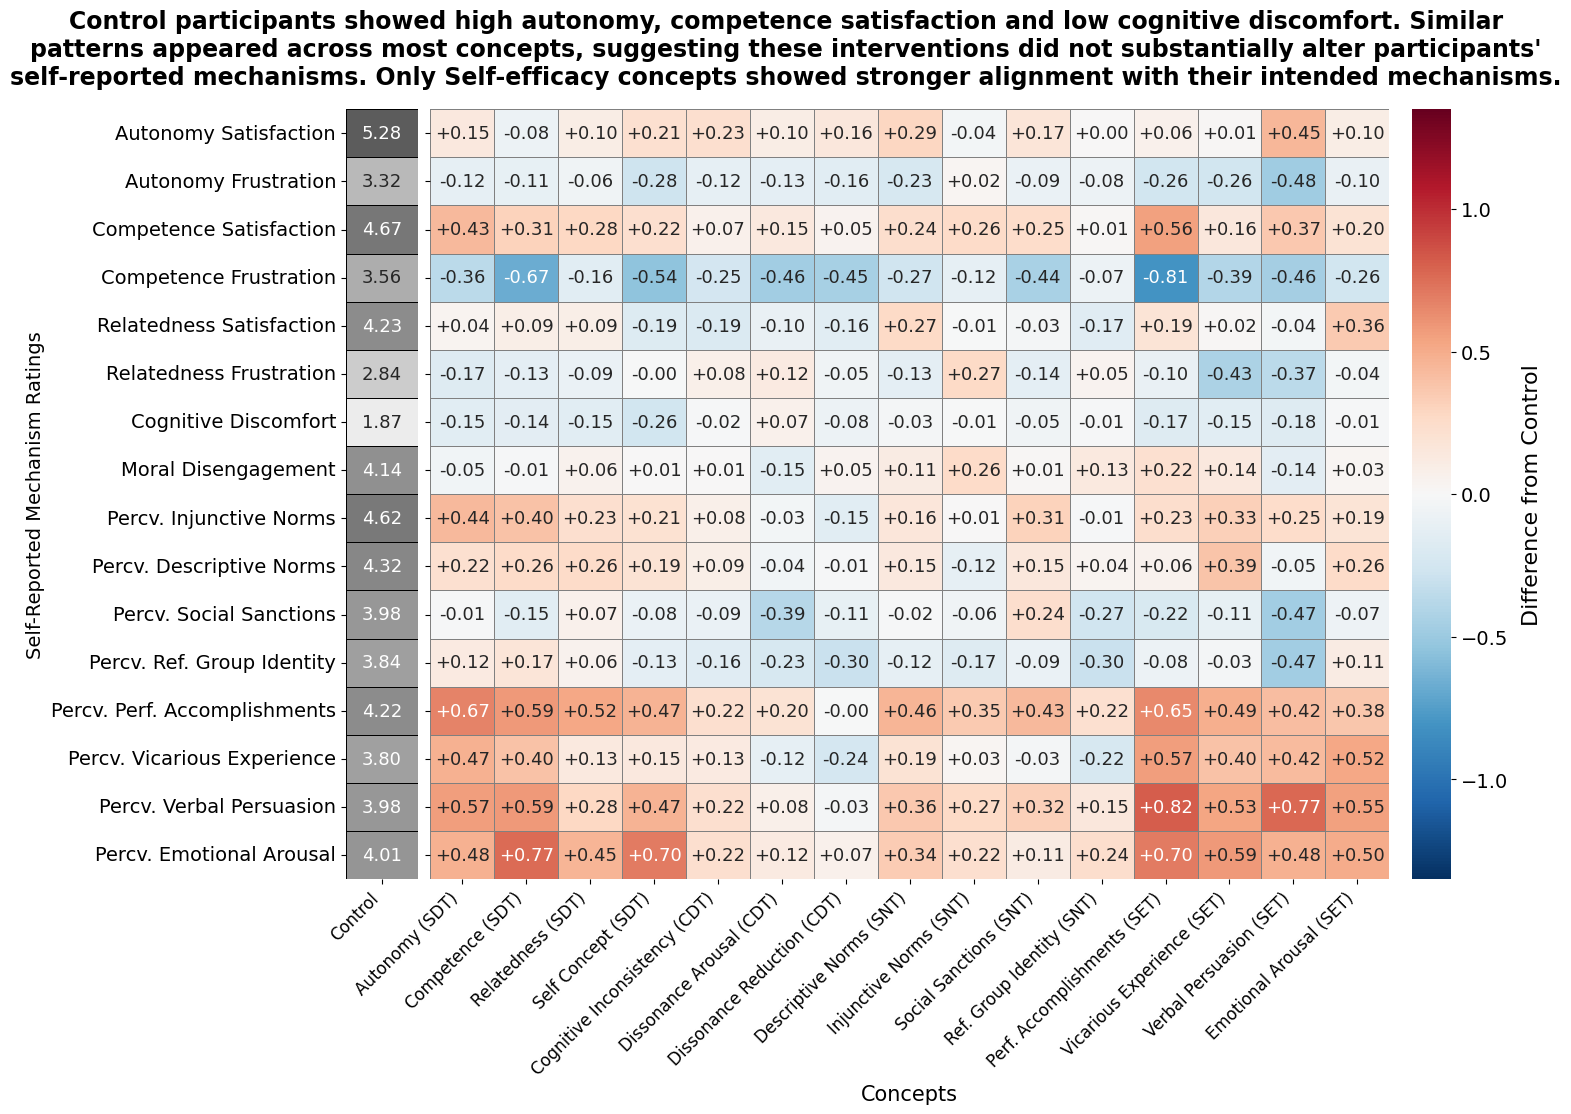

In [14]:
# =============================================================================
# FIGURE 4.9: Concept → Mechanism Heatmap (Two-Panel Layout)
# =============================================================================

# Prepare data
plot_data = pd.concat([
    control_means.to_frame('control'),
    relative_data.T
], axis=1)

concepts_without_control = [c for c in concept_order_filtered if c != 'control']
plot_columns = ['control'] + concepts_without_control
plot_data = plot_data[plot_columns]
plot_data.index = plot_data.index.map(MECHANISM_DISPLAY)
plot_data.columns = plot_data.columns.map(CONCEPT_DISPLAY)

# Annotations
annot_array = plot_data.copy()
annot_array.iloc[:, 0] = annot_array.iloc[:, 0].apply(lambda x: f"{x:.2f}")
annot_array.iloc[:, 1:] = annot_array.iloc[:, 1:].applymap(lambda x: f"{x:+.2f}")

# Scale for relative differences
relative_values = plot_data.iloc[:, 1:].values.flatten()
vmin = np.floor(np.nanmin(relative_values) * 10) / 10
vmax = np.ceil(np.nanmax(relative_values) * 10) / 10
scale_factor = 1.5
vmin_scaled, vmax_scaled = vmin * scale_factor, vmax * scale_factor

# Create figure with two panels
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 16], wspace=0.02)
ax_control = fig.add_subplot(gs[0])
ax_main = fig.add_subplot(gs[1])

# Control column (grayscale)
control_data = plot_data.iloc[:, 0:1]
control_annot = annot_array.iloc[:, 0:1]

sns.heatmap(control_data, annot=control_annot, fmt="", cmap='Greys',
            vmin=1, vmax=7, cbar=False, linewidths=0.5, linecolor='black',
            annot_kws={'size': 13}, ax=ax_control)

ax_control.set_ylabel("Self-Reported Mechanism Ratings", fontsize=14)
ax_control.set_xlabel("")
ax_control.set_xticklabels(ax_control.get_xticklabels(), rotation=45, ha='right', fontsize=12)
ax_control.set_yticklabels(ax_control.get_yticklabels(), fontsize=14)

# Intervention columns (RdBu_r diverging)
intervention_data = plot_data.iloc[:, 1:]
intervention_annot = annot_array.iloc[:, 1:]

sns.heatmap(intervention_data, annot=intervention_annot, fmt="", cmap='RdBu_r',
            center=0, vmin=vmin_scaled, vmax=vmax_scaled,
            cbar_kws={'label': 'Difference from Control', 'pad': 0.02},
            linewidths=0.5, linecolor='gray', annot_kws={'size': 13}, ax=ax_main)

cbar = ax_main.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('Difference from Control', fontsize=16, labelpad=10)

ax_main.set_ylabel("")
ax_main.set_yticklabels([])
ax_main.set_xlabel("Concepts", fontsize=15)
ax_main.set_xticklabels(ax_main.get_xticklabels(), rotation=45, ha='right', fontsize=12)

fig.suptitle(
    "Control participants showed high autonomy, competence satisfaction and low cognitive discomfort. Similar\n"
    "patterns appeared across most concepts, suggesting these interventions did not substantially alter participants'\n"
    "self-reported mechanisms. Only Self-efficacy concepts showed stronger alignment with their intended mechanisms.",
    fontsize=17, fontweight='bold', x=0.4, y=0.98)

plt.tight_layout()
plt.savefig('mechanism_activation_by_concept.png', dpi=300, bbox_inches='tight')
plt.show()

#### 4.2. Mechanism → Outcome Effects: Do self-reported mechanisms predict cheating, performance, and experience?

In [15]:
# =============================================================================
# RQ3: Logistic Regression - Mechanisms Predicting Integrity Group Membership
# =============================================================================

df_int = df_combined[df_combined['condition'] == 'intervention'].copy()
X = df_int[MECHANISMS].dropna()
valid_idx = X.index

print("="*70)
print("LOGISTIC REGRESSION: Mechanisms Predicting Integrity Group Membership")
print("="*70)
print(f"Participants with complete data: {len(X)}")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Results storage
lr_results = []
coef_results = {}
importance_results = {}

for group in ['non_cheaters', 'partial_cheaters', 'full_cheaters']:
    y = (df_int.loc[valid_idx, 'integrity_group'] == group).astype(int)
    
    # Likelihood ratio test
    lr_stat, df_lr, p_val, pseudo_r2 = likelihood_ratio_test(X_scaled, y)
    
    # Fit model for coefficients
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_scaled, y)
    
    # Permutation importance
    perm_imp = permutation_importance(model, X_scaled, y, n_repeats=30, random_state=42)
    
    lr_results.append({
        'Group': group.replace('_', '-').title(),
        'LR χ²': f"{lr_stat:.2f}",
        'df': df_lr,
        'p': f"{p_val:.4f}",
        'Sig': sig_stars(p_val),
        'Pseudo R²': f"{pseudo_r2:.3f}"
    })
    
    coef_results[group] = dict(zip(MECHANISMS, model.coef_[0]))
    importance_results[group] = dict(zip(MECHANISMS, perm_imp.importances_mean))

print("\n--- Model Comparison (Full vs Null) ---")
print(pd.DataFrame(lr_results).to_string(index=False))

print("\n--- Permutation Importance (Top 5 per group) ---")
for group, imps in importance_results.items():
    sorted_imps = sorted(imps.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"\n{group.replace('_', '-').title()}:")
    for mech, imp in sorted_imps:
        print(f"  {MECHANISM_DISPLAY[mech]:30s}: {imp:.4f}")

LOGISTIC REGRESSION: Mechanisms Predicting Integrity Group Membership
Participants with complete data: 1159

--- Model Comparison (Full vs Null) ---
           Group LR χ²  df      p Sig Pseudo R²
    Non-Cheaters 38.75  16 0.0012  **     0.025
Partial-Cheaters 13.50  16 0.6361  ns     0.013
   Full-Cheaters 56.91  16 0.0000 ***     0.050

--- Permutation Importance (Top 5 per group) ---

Non-Cheaters:
  Competence Frustration        : 0.0061
  Cognitive Discomfort          : 0.0040
  Percv. Emotional Arousal      : 0.0038
  Autonomy Satisfaction         : 0.0020
  Moral Disengagement           : 0.0012

Partial-Cheaters:
  Percv. Perf. Accomplishments  : 0.0003
  Autonomy Satisfaction         : 0.0000
  Autonomy Frustration          : 0.0000
  Competence Satisfaction       : 0.0000
  Competence Frustration        : 0.0000

Full-Cheaters:
  Percv. Injunctive Norms       : 0.0035
  Relatedness Frustration       : 0.0005
  Cognitive Discomfort          : 0.0004
  Competence Frustration  

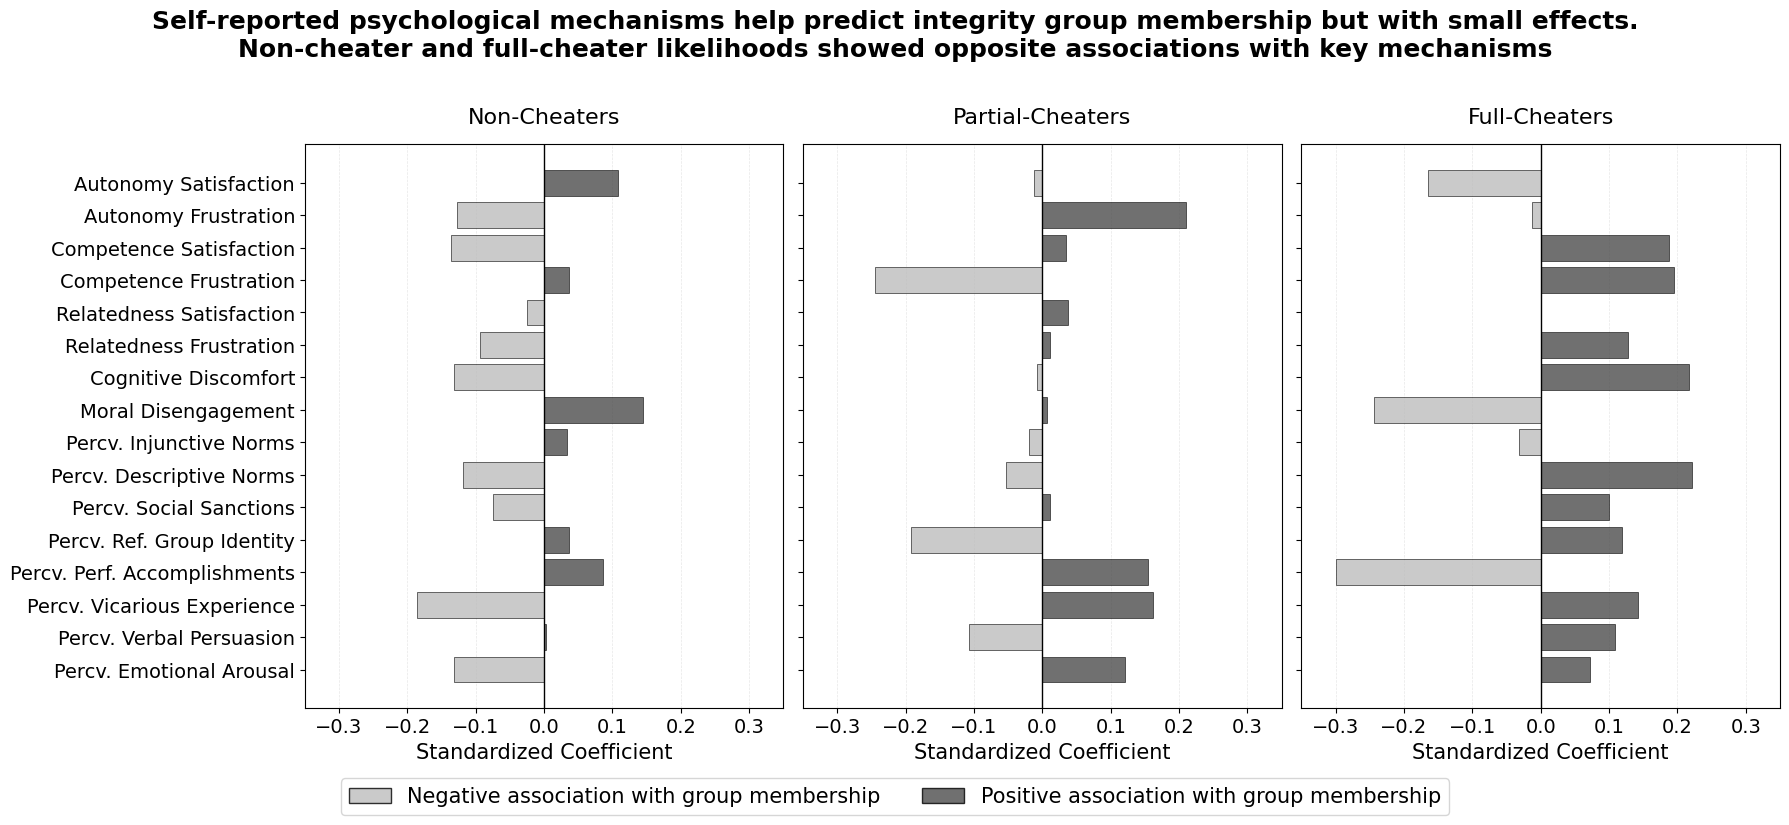

In [16]:
# =============================================================================
# FIGURE 4.10: Logistic Regression Coefficients (Bar Charts)
# =============================================================================


fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharey=True)
groups = ['non_cheaters', 'partial_cheaters', 'full_cheaters']
titles = ['Non-Cheaters', 'Partial-Cheaters', 'Full-Cheaters']

# Color scheme from original
positive_color = "#4C4C4C"  # Dark grey for positive associations
negative_color = "#bdbdbd"  # Light grey for negative associations

for idx, (group, title, ax) in enumerate(zip(groups, titles, axes)):
    coefs = coef_results[group]
    
    # Get coefficient values in mechanism order
    values = [coefs[m] for m in MECHANISMS]
    colors = [positive_color if v > 0 else negative_color for v in values]
    
    # Create horizontal bar plot
    ax.barh(range(len(MECHANISMS)), values, color=colors, alpha=0.8,
            edgecolor='black', linewidth=0.5)
    
    ax.set_xlim(-0.35, 0.35)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax.set_xlabel('Standardized Coefficient', fontsize=15)
    ax.set_title(title, fontsize=16, pad=15)
    
    if idx == 0:
        ax.set_yticks(range(len(MECHANISMS)))
        ax.set_yticklabels([MECHANISM_DISPLAY[m] for m in MECHANISMS][::-1], fontsize=14)
    
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
    ax.set_axisbelow(True)

fig.suptitle(
    "Self-reported psychological mechanisms help predict integrity group membership but with small effects.\nNon-cheater and "
    "full-cheater likelihoods showed opposite associations with key mechanisms",
    fontsize=18, fontweight='bold', y=0.98
)

legend_elements = [
    Patch(facecolor=negative_color, alpha=0.8, edgecolor='black', 
          label='Negative association with group membership'),
    Patch(facecolor=positive_color, alpha=0.8, edgecolor='black', 
          label='Positive association with group membership')
]
fig.legend(handles=legend_elements, loc='lower center', 
           ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, -0.04))

plt.tight_layout(rect=[0, 0.02, 1, 0.96])
plt.savefig('mechanism_logistic_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

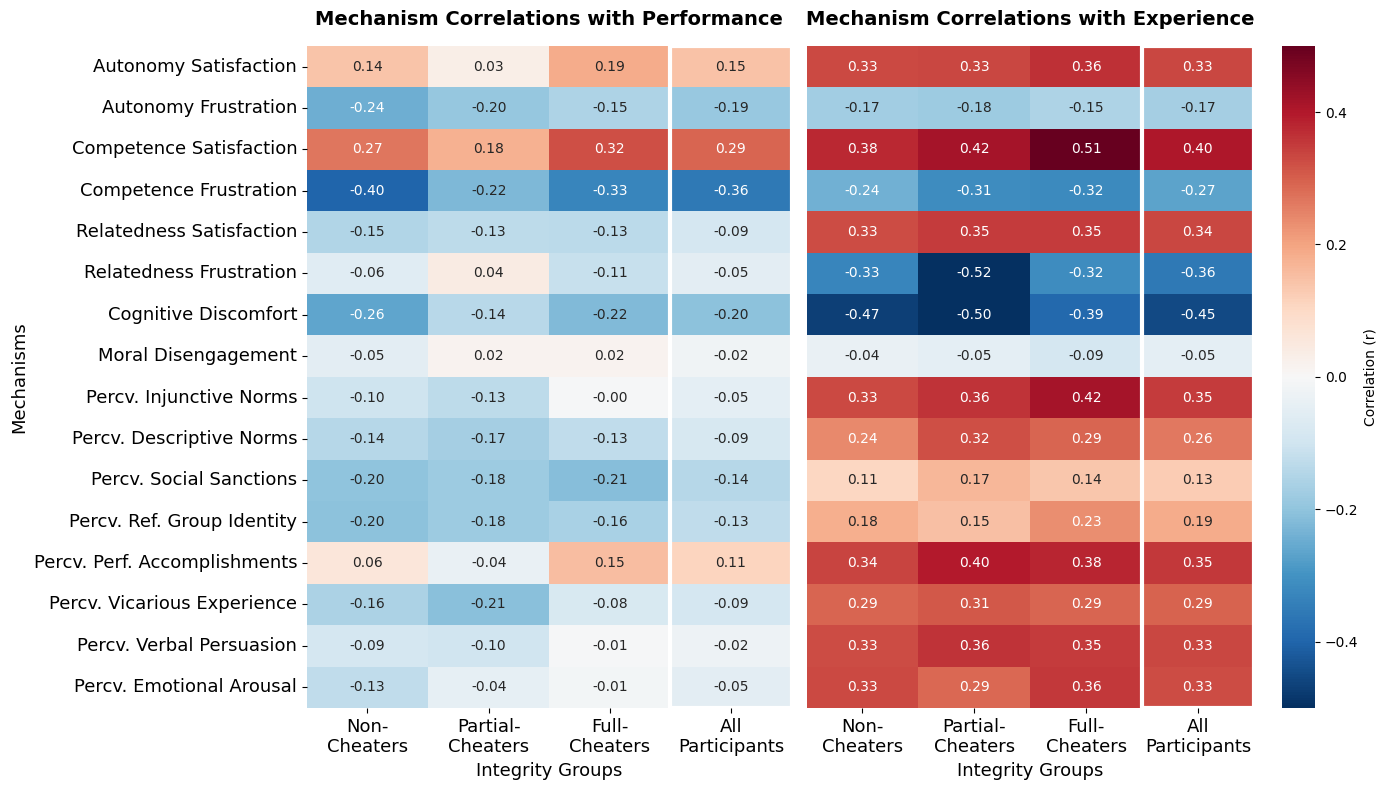

In [17]:
# =============================================================================
# FIGURE 4.11: Mechanism Correlations with Performance and Experience
# =============================================================================

df_int = df_combined[df_combined['condition'] == 'intervention'].copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 8), width_ratios=[1.3, 1.5])
integrity_groups = ['non_cheaters', 'partial_cheaters', 'full_cheaters']
group_labels = ['Non-\nCheaters', 'Partial-\nCheaters', 'Full-\nCheaters', 'All\nParticipants']
outcomes = ['performance', 'experience']
outcome_titles = ['Performance', 'Experience']

for outcome_idx, (outcome, outcome_title) in enumerate(zip(outcomes, outcome_titles)):
    corr_matrix = []
    
    # Individual groups
    for group in integrity_groups:
        group_data = df_int[df_int['integrity_group'] == group]
        correlations = [group_data[mech].corr(group_data[outcome]) for mech in MECHANISMS]
        corr_matrix.append(correlations)
    
    # All participants
    all_correlations = [df_int[mech].corr(df_int[outcome]) for mech in MECHANISMS]
    corr_matrix.append(all_correlations)
    
    corr_matrix = np.array(corr_matrix).T
    y_labels = [MECHANISM_DISPLAY[m] for m in MECHANISMS]
    
    # Plot heatmap
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                vmin=-0.5, vmax=0.5, xticklabels=group_labels,
                yticklabels=y_labels if outcome_idx == 0 else [],
                ax=axes[outcome_idx], cbar=outcome_idx == 1,
                cbar_kws={'label': 'Correlation (r)'} if outcome_idx == 1 else None)
    
    # Highlight "All" column
    num_rows, num_cols = corr_matrix.shape
    rect = Rectangle((num_cols-1, 0), 1, num_rows, fill=False, edgecolor='white', linewidth=3)
    axes[outcome_idx].add_patch(rect)
    
    axes[outcome_idx].set_title(f'Mechanism Correlations with {outcome_title}',
                                fontsize=14, fontweight='bold', pad=15)
    axes[outcome_idx].set_xlabel('Integrity Groups', fontsize=13)
    if outcome_idx == 0:
        axes[outcome_idx].set_ylabel('Mechanisms', fontsize=13)
    axes[outcome_idx].tick_params(axis='x', labelsize=13)
    axes[outcome_idx].tick_params(axis='y', labelsize=13)

plt.tight_layout()
plt.savefig('mechanism_correlations_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

#### 5. Additional Analysis: Performance-Experience Relationship
##### This section explores how performance and experience relate across integrity groups.

In [18]:
# =============================================================================
# Performance-Experience Correlations Across Integrity Groups
# =============================================================================

print("="*70)
print("PERFORMANCE-EXPERIENCE CORRELATIONS BY INTEGRITY GROUP")
print("="*70)

df_int = df_combined.copy()
correlations = {}

for group in ['non_cheaters', 'partial_cheaters', 'full_cheaters']:
    group_data = df_int[df_int['integrity_group'] == group][['performance', 'experience']].dropna()
    if len(group_data) > 2:
        r, p = pearsonr(group_data['performance'], group_data['experience'])
        n = len(group_data)
        correlations[group] = {'r': r, 'p': p, 'n': n}
        print(f"{group.replace('_', '-').title():20s}: r={r:.3f}, p={p:.4f} {sig_stars(p)}, n={n}")

# Fisher's Z-tests
print("\n" + "-"*70)
print("Fisher's Z-Tests (Comparing Correlations Between Groups)")
print("-"*70)

comparisons = [
    ('non_cheaters', 'partial_cheaters'),
    ('non_cheaters', 'full_cheaters'),
    ('partial_cheaters', 'full_cheaters')
]

for g1, g2 in comparisons:
    z_stat, p_val, diff = fishers_z_test(
        correlations[g1]['r'], correlations[g1]['n'],
        correlations[g2]['r'], correlations[g2]['n']
    )
    print(f"{g1.replace('_', '-').title()} vs {g2.replace('_', '-').title()}:")
    print(f"  Z = {z_stat:.3f}, p = {p_val:.4f} {sig_stars(p_val)}")

PERFORMANCE-EXPERIENCE CORRELATIONS BY INTEGRITY GROUP
Non-Cheaters        : r=0.120, p=0.0000 ***, n=1507
Partial-Cheaters    : r=-0.009, p=0.8584 ns, n=416
Full-Cheaters       : r=0.219, p=0.0000 ***, n=468

----------------------------------------------------------------------
Fisher's Z-Tests (Comparing Correlations Between Groups)
----------------------------------------------------------------------
Non-Cheaters vs Partial-Cheaters:
  Z = 2.334, p = 0.0196 *
Non-Cheaters vs Full-Cheaters:
  Z = -1.923, p = 0.0544 ns
Partial-Cheaters vs Full-Cheaters:
  Z = -3.427, p = 0.0006 ***


## Summary
#### This analysis examined concept-based interventions designed to reduce cheating behavior:
1. **RQ1**: Interventions reduced full-cheaters by ~42% (χ²=7.26, p=.007). Effects were consistent across all concepts.
2. **RQ2**: No significant differences in performance or experience between control and intervention conditions for any integrity group.
3. **RQ3**:    
    - Concept-based messages affected multiple mechanisms rather than uniquely targeting intended mechanisms
    - Self-reported mechanisms as a group modestly predicted cheating behavior (pseudo-R² = .013–.047)   
    - Competence satisfaction positively correlated with both performance and experience across all groups
4. **Performance-Experience Relationship**: Correlations differed across groups: weak for non-cheaters (r=.12), moderate for full-cheaters (r=.22), and non-significant for partial-cheaters.